### Imports

In [1]:
import pandas as pd
import datetime as dt

matches = pd.read_csv("matches.csv", index_col=0)

### Data Cleaning and Feature Engineering

In [2]:
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,15/08/2021,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,Match Report,NaN,18,4,16.9,1,0,0,2022,Manchester City
2,21/08/2021,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,Match Report,NaN,16,4,17.3,1,0,0,2022,Manchester City
3,28/08/2021,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,...,Match Report,NaN,25,10,14.3,0,0,0,2022,Manchester City
4,11/09/2021,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,...,Match Report,NaN,25,8,14.0,0,0,0,2022,Manchester City
6,18/09/2021,15:00,Premier League,Matchweek 5,Sat,Home,D,0,0,Southampton,...,Match Report,NaN,16,1,15.7,1,0,0,2022,Manchester City


In [3]:
matches.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team'],
      dtype='object')

In [4]:
matches.drop(["round", 
              "comp", 
              "season", 
              "attendance", 
              "notes", 
              "captain", 
              "formation", 
              "referee", 
              "match report", 
              "notes"], 
             axis=1, inplace=True)

In [5]:
matches["team"].value_counts()

Brighton and Hove Albion    72
Southampton                 72
Manchester United           72
West Ham United             72
Newcastle United            72
Crystal Palace              71
Tottenham Hotspur           71
Arsenal                     71
Wolverhampton Wanderers     71
Burnley                     71
Leeds United                71
Manchester City             71
Aston Villa                 70
Leicester City              70
Everton                     70
Chelsea                     70
Liverpool                   38
West Bromwich Albion        38
Fulham                      38
Sheffield United            38
Brentford                   34
Norwich City                33
Watford                     33
Name: team, dtype: int64

In [6]:
#convert categoric variables to numeric for machine learning model

In [7]:
matches["date"] = pd.to_datetime(matches["date"])

In [8]:
matches["venue_code"] = matches["venue"].astype("category").cat.codes

In [9]:
matches["day_code"] = matches["date"].dt.dayofweek

In [10]:
#retrieve just hour from ko time - time of day may affect performance
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype(int)

In [11]:
#create dict to rename teams so they match in home/away column
class MissingDict(dict):
    __missing__ = lambda self, key: key
    
map_values = {  
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",    
}
mapping = MissingDict(**map_values)

In [12]:
matches['team'] = matches['team'].map(mapping)

In [13]:
matches.head()

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,sh,sot,dist,fk,pk,pkatt,team,venue_code,day_code,hour
1,2021-08-15,16:30,Sun,Away,L,0,1,Tottenham,1.9,1.3,...,18,4,16.9,1,0,0,Manchester City,0,6,16
2,2021-08-21,15:00,Sat,Home,W,5,0,Norwich City,2.7,0.1,...,16,4,17.3,1,0,0,Manchester City,1,5,15
3,2021-08-28,12:30,Sat,Home,W,5,0,Arsenal,3.8,0.1,...,25,10,14.3,0,0,0,Manchester City,1,5,12
4,2021-11-09,15:00,Sat,Away,W,1,0,Leicester City,2.9,0.8,...,25,8,14.0,0,0,0,Manchester City,0,1,15
6,2021-09-18,15:00,Sat,Home,D,0,0,Southampton,1.1,0.4,...,16,1,15.7,1,0,0,Manchester City,1,5,15


In [14]:
#determine points acquired
matches["points"] = matches["result"].apply(lambda row: 3 if row=="W" else 1 if row=="D" else 0)

In [15]:
#convert W/L/D to numbers for classification
matches["results_class"] = matches["result"].apply(lambda row: 2 if row=="W" else 1 if row=="D" else 0)

In [16]:
matches.columns

Index(['date', 'time', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg',
       'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'team',
       'venue_code', 'day_code', 'hour', 'points', 'results_class'],
      dtype='object')

In [17]:
matches.sort_values('date', inplace=True)

In [18]:
#create rolling averages based on previous 4 games
cols = ['points', 'gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'poss', 'xg', 'xga']
new_cols = [f"{c}_rolling" for c in cols]
matches[new_cols] = matches.groupby('team')[cols].transform(lambda x: x.rolling(4).mean().shift().bfill())

In [19]:
#group by team
grp_matches = matches.groupby("team").apply(lambda a: a[:]).drop('team', axis=1).droplevel(1)

In [20]:
grp_matches.reset_index(inplace=True)

In [21]:
#keep important columns that have potential impact on performance
avg_matches = grp_matches[['date', 
                           'team',
                           'opponent',
                           'venue_code', 
                           'hour', 
                           'day_code', 
                           'points_rolling', 
                           'gf_rolling', 
                           'ga_rolling', 
                           'sh_rolling', 
                           'sot_rolling', 
                           'dist_rolling', 
                           'fk_rolling', 
                           'pk_rolling', 
                           'pkatt_rolling',
                           'poss_rolling',
                           'xg_rolling', 
                           'xga_rolling', 
                           'results_class']].dropna(axis=0)

In [22]:
#split in to home and awya matches based on venue code
home_matches = avg_matches[avg_matches["venue_code"]==1].sort_values("date")
away_matches = avg_matches[avg_matches["venue_code"]==0].sort_values("date")

In [23]:
home_matches.head()

,date,team,opponent,venue_code,hour,day_code,points_rolling,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,poss_rolling,xg_rolling,xga_rolling,results_class
1104,2020-01-11,Tottenham,Brighton,1,19,5,3.00,2.75,0.50,13.50,4.25,17.425,1.00,0.50,0.50,49.25,1.925,0.725,2
889,2020-01-11,Newcastle Utd,Everton,1,14,5,1.50,1.25,1.75,7.00,2.25,17.400,0.25,0.50,0.50,42.75,1.375,1.075,2
817,2020-01-11,Manchester Utd,Arsenal,1,16,5,1.50,1.75,2.25,10.25,3.50,20.150,0.50,0.25,0.25,49.00,1.175,1.925,0
71,2020-01-11,Aston Villa,Southampton,1,12,5,2.25,3.50,1.50,17.75,6.75,15.125,0.25,0.25,0.25,50.50,2.100,1.225,0
567,2020-02-11,Leeds United,Leicester City,1,20,1,0.25,1.00,3.00,10.25,4.50,15.600,0.25,0.00,0.00,59.25,1.200,2.400,0


In [24]:
away_matches.head()

,date,team,opponent,venue_code,hour,day_code,points_rolling,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,poss_rolling,xg_rolling,xga_rolling,results_class
0,2020-01-11,Arsenal,Manchester Utd,0,16,5,1.50,0.75,1.5,9.25,2.50,17.525,0.25,0.25,0.25,59.00,0.950,0.675,2
175,2020-01-11,Brighton,Tottenham,0,19,5,0.25,1.00,2.0,11.75,2.75,16.175,0.50,0.25,0.25,55.25,1.250,1.250,0
459,2020-01-11,Everton,Newcastle Utd,0,14,5,1.00,1.75,2.0,11.50,4.25,16.775,0.00,0.00,0.00,55.00,1.325,1.525,0
1032,2020-01-11,Southampton,Aston Villa,0,12,5,3.00,2.50,1.0,11.50,5.00,17.825,0.50,0.25,0.25,54.50,0.975,1.125,2
1208,2020-02-11,West Brom,Fulham,0,17,1,0.00,0.25,2.5,9.00,2.50,18.675,0.25,0.00,0.00,45.50,0.550,1.525,0


In [25]:
#remerge so no matches are repeated
merge_matches = pd.merge(home_matches, away_matches, 
                         left_on=["date", "team", "opponent"], 
                         right_on=["date", "opponent", "team"], 
                         suffixes=('_home', '_away')).sort_values("date")

In [26]:
merge_matches.drop(["opponent_home", "opponent_away", "venue_code_home", "venue_code_away", "results_class_away", "hour_away", "day_code_away"], axis=1, inplace=True)

In [27]:
merge_matches.columns

Index(['date', 'team_home', 'hour_home', 'day_code_home',
       'points_rolling_home', 'gf_rolling_home', 'ga_rolling_home',
       'sh_rolling_home', 'sot_rolling_home', 'dist_rolling_home',
       'fk_rolling_home', 'pk_rolling_home', 'pkatt_rolling_home',
       'poss_rolling_home', 'xg_rolling_home', 'xga_rolling_home',
       'results_class_home', 'team_away', 'points_rolling_away',
       'gf_rolling_away', 'ga_rolling_away', 'sh_rolling_away',
       'sot_rolling_away', 'dist_rolling_away', 'fk_rolling_away',
       'pk_rolling_away', 'pkatt_rolling_away', 'poss_rolling_away',
       'xg_rolling_away', 'xga_rolling_away'],
      dtype='object')

In [28]:
merge_matches.rename({"hour_home": "hour", "day_code_home": "day_code"}, axis=1, inplace=True)

In [29]:
merge_matches.columns

Index(['date', 'team_home', 'hour', 'day_code', 'points_rolling_home',
       'gf_rolling_home', 'ga_rolling_home', 'sh_rolling_home',
       'sot_rolling_home', 'dist_rolling_home', 'fk_rolling_home',
       'pk_rolling_home', 'pkatt_rolling_home', 'poss_rolling_home',
       'xg_rolling_home', 'xga_rolling_home', 'results_class_home',
       'team_away', 'points_rolling_away', 'gf_rolling_away',
       'ga_rolling_away', 'sh_rolling_away', 'sot_rolling_away',
       'dist_rolling_away', 'fk_rolling_away', 'pk_rolling_away',
       'pkatt_rolling_away', 'poss_rolling_away', 'xg_rolling_away',
       'xga_rolling_away'],
      dtype='object')

In [30]:
merge_matches["team_home_code"] = merge_matches["team_home"].astype("category").cat.codes

In [31]:
merge_matches["team_away_code"] = merge_matches["team_away"].astype("category").cat.codes

In [32]:
# create columns with average stat differences between the two teams
merge_matches['points_rolling_diff'] = (merge_matches['points_rolling_home']-merge_matches['points_rolling_away'])
merge_matches['gf_rolling_diff'] = (merge_matches['gf_rolling_home']-merge_matches['gf_rolling_away'])
merge_matches['ga_rolling_diff'] = (merge_matches['ga_rolling_home']-merge_matches['ga_rolling_away'])
merge_matches['sh_rolling_diff'] = (merge_matches['sh_rolling_home']-merge_matches['sh_rolling_away'])
merge_matches['sot_rolling_diff'] = (merge_matches['sot_rolling_home']-merge_matches['sot_rolling_away'])
merge_matches['poss_rolling_diff'] = (merge_matches['poss_rolling_home']-merge_matches['poss_rolling_away'])
merge_matches['xg_rolling_diff'] = (merge_matches['xg_rolling_home']-merge_matches['xg_rolling_away'])
merge_matches['xga_rolling_diff'] = (merge_matches['xga_rolling_home']-merge_matches['xga_rolling_away'])

In [33]:
#final column features
final_df = merge_matches[['date',
                          'hour', 
                          'day_code', 
                          'team_home',
                          'team_away', 
                          'points_rolling_diff', 
                          'gf_rolling_diff', 
                          'ga_rolling_diff', 
                          'sh_rolling_diff', 
                          'sot_rolling_diff', 
                          'poss_rolling_diff', 
                          'xg_rolling_diff', 
                          'xga_rolling_diff', 
                          'results_class_home']]

<AxesSubplot: >

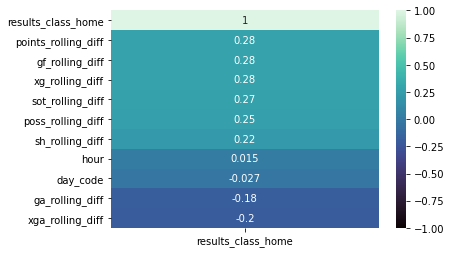

In [34]:
#observe correlations between features and target 
import seaborn as sns

sns.heatmap(final_df.corr()[['results_class_home']].sort_values("results_class_home", ascending=False), annot=True, cmap="mako", vmax=1, vmin=-1)

In [35]:
final_df.head()

,date,hour,day_code,team_home,team_away,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,results_class_home
0,2020-01-11,19,5,Tottenham,Brighton,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,2
1,2020-01-11,14,5,Newcastle Utd,Everton,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,2
2,2020-01-11,16,5,Manchester Utd,Arsenal,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,0
3,2020-01-11,12,5,Aston Villa,Southampton,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,0
4,2020-02-11,20,1,Leeds United,Leicester City,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,0


In [36]:
#convert team names to numeric codes for machine learning model
final_df["team_home_code"] = final_df["team_home"].astype("category").cat.codes
final_df["team_away_code"] = final_df["team_away"].astype("category").cat.codes

<ipython-input-36-e5743ac03b79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["team_home_code"] = final_df["team_home"].astype("category").cat.codes
<ipython-input-36-e5743ac03b79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["team_away_code"] = final_df["team_away"].astype("category").cat.codes


## Machine Learning Model

In [37]:
#train = final_df[final_df["date"] < "2022-01-01"].select_dtypes(['number'])

In [38]:
#test = final_df[final_df["date"] > "2022-01-01"].select_dtypes(['number'])

In [39]:
#select only numeric features for model
final_df = final_df.select_dtypes(['number'])

In [40]:
final_df.head()

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,results_class_home,team_home_code,team_away_code
0,19,5,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,2,18,3
1,14,5,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,2,14,7
2,16,5,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,0,13,0
3,12,5,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,0,1,17
4,20,1,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,0,9,10


In [248]:
# test/train split based on time - 67% train 33% test
import numpy as np 

train, test = np.split(final_df, [int(.8*len(final_df))])
train, val = np.split(train, [int(.8*len(train))])

In [249]:
#normalise feature values
# from sklearn import preprocessing

# d = preprocessing.normalize(final_df.drop("results_class_home", axis=1), axis=0)
# scaled_df = pd.DataFrame(d, columns=final_df.drop("results_class_home", axis=1).columns)
# scaled_df = scaled_df.join(final_df["results_class_home"])

In [250]:
# scaled_df.head()

In [251]:
train

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,results_class_home,team_home_code,team_away_code
0,19,5,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,2,18,3
1,14,5,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,2,14,7
2,16,5,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,0,13,0
3,12,5,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,0,1,17
4,20,1,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,0,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,15,5,1.00,1.75,-1.25,6.75,1.25,15.00,1.050,-1.275,1,12,17
426,12,5,0.25,-0.25,0.00,3.00,1.25,4.00,-0.175,-0.150,0,22,2
427,15,5,0.00,0.00,1.25,-0.50,0.25,-0.75,0.275,0.750,0,15,19
431,14,6,-0.75,0.00,0.75,0.75,-0.50,-1.25,0.450,0.250,0,21,13


In [252]:
test

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,results_class_home,team_home_code,team_away_code
542,19,2,0.00,0.50,0.50,-3.00,1.25,11.25,0.775,-3.500000e-01,1,5,3
543,20,3,0.75,0.00,0.00,-5.25,0.25,12.50,0.025,5.250000e-01,2,13,4
544,12,5,0.00,-1.50,-0.50,-3.75,-1.50,-20.50,-0.425,2.000000e-01,0,0,12
545,17,5,0.75,0.50,0.00,0.25,1.00,-1.25,-0.125,-6.661338e-16,0,6,21
546,15,5,-1.25,-0.25,1.75,-1.50,-1.50,-9.75,-1.025,1.400000e+00,0,19,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,12,4,-1.25,-1.25,-0.50,-0.75,-1.25,2.25,-0.175,-3.000000e-01,1,13,17
672,15,4,0.25,0.50,1.00,-3.25,-1.00,-11.25,-0.475,7.250000e-01,1,2,6
675,15,4,-1.00,-0.75,0.75,1.00,-1.00,-6.25,0.150,-3.750000e-01,0,19,3
676,15,5,0.00,-0.25,-0.75,-2.50,1.25,-1.25,-0.050,-9.500000e-01,2,2,4


In [253]:
val

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,results_class_home,team_home_code,team_away_code
433,14,6,-0.25,0.00,-0.25,3.75,0.75,6.25,0.050,-0.425,2,3,10
438,15,5,2.25,1.00,-2.25,1.25,0.50,-3.00,0.300,-0.775,2,7,15
434,12,5,0.75,-0.25,0.00,-3.50,0.75,-14.75,-0.750,0.500,0,5,12
435,15,5,-0.25,-0.50,0.75,1.50,1.00,10.50,-0.200,0.300,0,9,21
436,15,5,1.00,0.25,-0.75,-2.00,0.50,1.75,-0.100,-1.125,1,19,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,20,0,-1.50,-0.50,1.75,-1.00,-1.75,-13.75,-0.750,0.450,1,14,13
540,15,1,-0.75,-0.50,1.25,0.75,-0.25,-1.50,-0.725,0.775,1,17,18
539,15,1,0.50,1.00,-0.25,-0.50,-0.50,0.25,0.125,0.150,2,6,15
538,15,1,0.50,0.75,0.25,2.75,1.25,-6.50,0.875,0.300,0,19,21


In [254]:
# from sklearn.model_selection import train_test_split

#test/train split - stratified sampling (equal weights of each class in test/train)
# X_train, X_test, y_train, y_test = train_test_split(final_df.drop("results_class_home", axis=1), final_df["results_class_home"], test_size=0.2, stratify = final_df["results_class_home"])

In [255]:
X_train = train.drop("results_class_home", axis=1)
y_train = train["results_class_home"]

In [256]:
X_test = test.drop("results_class_home", axis=1)
y_test = test["results_class_home"]

In [257]:
X_val = val.drop("results_class_home", axis=1)
y_val = val["results_class_home"]

In [258]:
X_train.head()

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,team_home_code,team_away_code
0,19,5,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,18,3
1,14,5,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,14,7
2,16,5,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,13,0
3,12,5,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,1,17
4,20,1,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,9,10


In [259]:
X_train.columns[1]

'day_code'

In [260]:
#viusalise general relationship between variables and target
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18, 10))
# ax.set_xlabel('Target', fontsize=10)
# ax.set_ylabel('Feature', fontsize='medium')

# x=y_train

# for i in range(len(X_train.columns)):
#     y=X_train.iloc[:,i]
#     plt.scatter(y=y, x=x, label=X_train.columns[i])
#     z = np.polyfit(x, y, 1)
#     p = np.poly1d(z)
#     plt.plot(x, p(x))
    
# ax.legend(loc='best', ncol=8)

In [261]:
import xgboost as xgb
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
from hyperopt.pyll import scope
import numpy as np

In [262]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['model']

In [263]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, cohen_kappa_score

### XGBoost Regression

In [264]:
# xgbreg = xgb.XGBRegressor(objective="reg:squarederror", 
#                           random_state=42
#                          )

In [265]:
# xgbreg.fit(X_train, y_train)

In [266]:
# y_pred = xgbreg.predict(X_test)

In [267]:
# len(y_test)

In [268]:
# len(y_pred)

In [269]:
# len(X_train.columns)

In [270]:
# from sklearn.metrics import r2_score

In [271]:
# r2_score(y_test, y_pred)

In [272]:
# def objective_xgbreg(space):
    
#     model = xgb.XGBRegressor(objective="reg:squarederror", 
#                              max_depth=int(space['max_depth']),
#                              min_child_weight=int(space['min_child_weight']),
#                              n_estimators=int(space['n_estimators']),
#                              eval_metric="rmse",
#                              early_stopping_rounds=10,
#                              random_state=42
#                             )
    
#     evaluation=[(X_test, y_test)]
    
#     model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    
#     y_pred = model.predict(X_test)
#     score = r2_score(y_test, y_pred)
    
#     loss = 1 - score
    
#     return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [273]:
# space={'max_depth': hp.quniform("max_depth", 1, 18, 1),
#        'min_child_weight' : hp.quniform('min_child_weight', 0, 1000, 1),
#        'n_estimators': hp.quniform("n_estimators", 1, 1000, 1)
#       }

In [274]:
# xgbreg_trials = Trials()

In [275]:
# best_params_xgb = fmin(
#     fn=objective_xgbreg,
#     space=space,
#     algo=tpe.suggest,
#     trials=xgb_trials,
#     max_evals=1000)

In [276]:
# print(best_params_xgb)

In [277]:
# xgbreg_model = getBestModelfromTrials(xgbreg_trials)

In [278]:
# pred = xgbreg_model.predict(X_test)

In [279]:
# pred_rnd = np.around(pred)

In [280]:
# r2_score(y_test, pred)

In [281]:
# xgbreg_model

### XGBoost Classification

In [282]:
xgbclf = xgb.XGBClassifier(objective="multi:softmax")

In [283]:
xgbclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

In [284]:
clf_pred = xgbclf.predict(X_test)

In [285]:
accuracy_score(y_test, clf_pred)

0.34558823529411764

In [301]:
def objective_xgbclf(space):
    
    model = xgb.XGBClassifier(objective="multi:softmax", 
                              num_class=3,
                              max_depth=space['max_depth'],
                              min_child_weight=space['min_child_weight'],
                              n_estimators=space['n_estimators'],
                              gamma=space['gamma'],
                              learning_rate=space['learning_rate'],
                              reg_lambda=space['reg_lambda'],
                              eval_metric="mlogloss",
                              early_stopping_rounds=space['early_stopping_rounds'],
                              subsample=space['subsample']
                             )
    
    evaluation=[(X_val, y_val)]
    
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    
    y_pred_probs = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    score1 = cohen_kappa_score(y_test, y_pred)
    score2 = roc_auc_score(y_test,y_pred_probs, multi_class='ovo')
    
    loss = 1-(0.7*score1+0.3*score2)/2
    
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [356]:
space={'max_depth': scope.int(hp.quniform("max_depth", 15, 17, 1)),
       'min_child_weight': scope.int(hp.quniform('min_child_weight', 14, 16, 1)),
       'n_estimators': scope.int(hp.quniform("n_estimators", 250, 300, 1)),
       'gamma': hp.quniform('gamma', 0.03, 0.1, 0.005),
       'learning_rate': hp.quniform('learning_rate', 0.31, 0.32, 0.005),
       'reg_lambda': hp.quniform('reg_lambda', 0.5, 1.5, 0.05),
       'early_stopping_rounds': hp.quniform('early_stopping_rounds', 100, 120, 2),
       'subsample': hp.quniform('subsample', 0.6, 0.7, 0.01)
      }

In [357]:
xgbclf_trials = Trials()

In [358]:
no_features = len(X_train.columns)

In [359]:
best_params_xgbclf = fmin(
    fn=objective_xgbclf,
    space=space,
    algo=tpe.suggest,
    trials=xgbclf_trials,
    max_evals=1000)

100%|██████████| 1000/1000 [08:41<00:00,  1.92trial/s, best loss: 0.8197184116779382]


In [361]:
best_params_xgbclf

{'early_stopping_rounds': 102.0,
 'gamma': 0.1,
 'learning_rate': 0.315,
 'max_depth': 15.0,
 'min_child_weight': 15.0,
 'n_estimators': 281.0,
 'reg_lambda': 1.0,
 'subsample': 0.63}

In [362]:
# print([t for t in xgbclf_trials][:5])

In [3]:
def unpack(x):
    if x:
        return x[0]
    return np.nan

In [4]:
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in xgbclf_trials])

NameError: name 'pd' is not defined

In [5]:
trials_df["loss"] = [t["result"]["loss"] for t in xgbclf_trials]
trials_df["trial_number"] = trials_df.index

NameError: name 'xgbclf_trials' is not defined

In [366]:
trials_df.head()

,early_stopping_rounds,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_lambda,subsample,loss,trial_number
0,100.0,0.055,0.310,16.0,15.0,273.0,0.60,0.69,0.873846,0
1,104.0,0.090,0.315,15.0,16.0,266.0,1.20,0.63,0.861816,1
2,110.0,0.050,0.315,15.0,15.0,292.0,0.95,0.69,0.854340,2
3,112.0,0.100,0.320,15.0,16.0,276.0,1.45,0.68,0.886644,3
4,104.0,0.045,0.315,16.0,16.0,296.0,0.80,0.67,0.893150,4


In [6]:
# https://medium.com/doma/visualizing-hyperparameter-optimization-with-hyperopt-and-plotly-states-title-26369b020b5
def contour_2d(parameter1, parameter2, constant, constant_val):
    
    from plotly import graph_objects as go
    filter = (trials_df[constant] == constant_val)
    fig = go.Figure(
        data=go.Contour(
            z=trials_df.loc[filter, "loss"],
            x=trials_df.loc[filter, parameter1],
            y=trials_df.loc[filter, parameter2],
            contours=dict(
                showlabels=True,  # show labels on contours
                labelfont=dict(size=12, color="white",),  # label font properties
            ),
            colorbar=dict(title="loss", titleside="right",),
            hovertemplate="loss: %{z}<br>"+parameter1+": %{x}<br>"+parameter2+": %{y}<extra></extra>",
        )
    )

    fig.update_layout(
        xaxis_title=parameter1,
        yaxis_title=parameter2,
        title={
            "text": parameter1 + " vs. " + parameter2 + " | " + constant + " == " + str(constant_val),
            "xanchor": "center",
            "yanchor": "top",
            "x": 0.5,
        },
    )
    
    return fig

In [2]:
contour_2d("min_child_weight", "gamma", "early_stopping_rounds", 102)

NameError: name 'trials_df' is not defined

In [371]:
"""
{'early_stopping_rounds': 114.0,
 'gamma': 0.04,
 'learning_rate': 0.318,
 'max_depth': 10.0,
 'min_child_weight': 20.0,
 'n_estimators': 390.0,
 'reg_lambda': 2.0,
 'subsample': 0.54}
"""

"\n{'early_stopping_rounds': 114.0,\n 'gamma': 0.04,\n 'learning_rate': 0.318,\n 'max_depth': 10.0,\n 'min_child_weight': 20.0,\n 'n_estimators': 390.0,\n 'reg_lambda': 2.0,\n 'subsample': 0.54}\n"

In [372]:
xgbclf = getBestModelfromTrials(xgbclf_trials)

In [373]:
evaluation=[(X_train, y_train), (X_test, y_test)]
xgbclf.fit(X_train, y_train, eval_set=evaluation, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=102.0, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.315, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=15, max_leaves=0, min_child_weight=15, missing=nan,
              monotone_constraints='()', n_estimators=281, n_jobs=0,
              num_class=3, num_parallel_tree=1, objective='multi:softmax', ...)

In [374]:
pred = xgbclf.predict(X_test)

In [375]:
pred

array([2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2,
       1, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0,
       2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0,
       2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 2, 1])

In [376]:
accuracy_score(y_test, pred)

0.4852941176470588

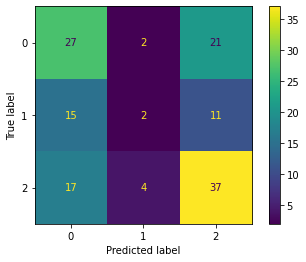

In [377]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_display.plot()
plt.show()

## xgbclf.best_ntree_limit

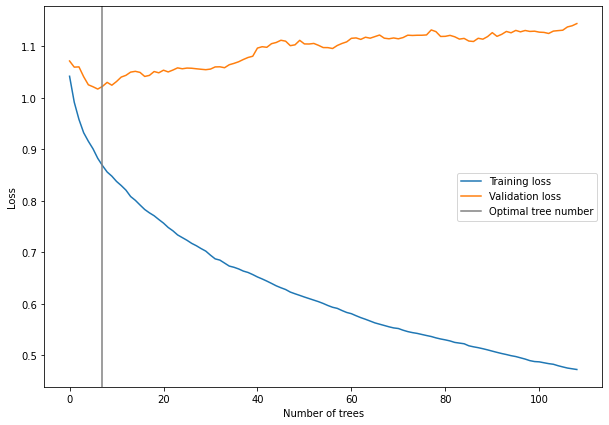

In [378]:
results = xgbclf.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(xgbclf.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [379]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

Text(0.5, 0, 'Feature Importance')

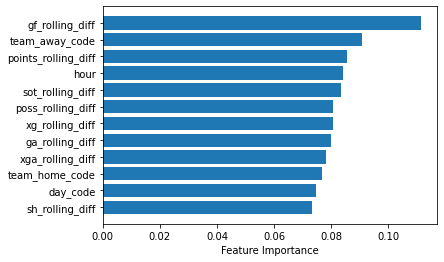

In [382]:
sort = xgbclf.feature_importances_.argsort()
plt.barh(X_train.columns[sort], xgbclf.feature_importances_[sort])
plt.xlabel("Feature Importance")

### Multi Classifier Model Test

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
names = ["Nearest Neighbors", "Logistic Regression","Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = cohen_kappa_score(y_test, y_pred)

    # prediction_proba = clf.predict_proba(X_test)
    # logloss = log_loss(y_test,prediction_proba)
    # precision, recall, fscore, support = score(y_test, prediction)
    # conf_martrix = confusion_matrix(y_test, prediction)
    # clas_report = classification_report(y_test, prediction)

    print(name, score)

### Linear SVM Optimisation

In [ ]:
# lin_svm = SVC(kernel="linear", C=0.025, probability=True)

In [ ]:
# lin_svm.fit(X_train, y_train)

In [ ]:
# svm_pred = lin_svm.predict(X_test)

In [ ]:
# accuracy_score(y_test, svm_pred)

In [ ]:
# def objective_svm(space):
    
#     model = SVC(C=space['C'],
#                 gamma=space['gamma'],
#                 degree=space['degree'],
#                 kernel='linear',
#                 probability=True
#                )
    
#     model.fit(X_train, y_train)
    
#     pred = model.predict(X_test)
#     score = cohen_kappa_score(y_test, pred)
    
#     loss = 1 - score
    
#     return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [ ]:
# space={'C': hp.loguniform('C', 0, 1),
#        'gamma' : hp.loguniform('gamma', 0, 1),
#        'degree': scope.int(hp.choice('degree', [1, 2, 3, 5]))
#       }

In [ ]:
# svm_trials = Trials()

In [ ]:
# best_params_svm = fmin(
#     fn=objective_svm,
#     space=space,
#     algo=tpe.suggest,
#     trials=svm_trials,
#     max_evals=200)

In [ ]:
# svm_model = getBestModelfromTrials(svm_trials)

In [ ]:
# pred = svm_model.predict(X_test)

In [ ]:
# pred

In [ ]:
# accuracy_score(y_test, pred)

In [ ]:
# svm_model